In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

In [2]:
titanic=pd.read_csv("./titanic_train.csv")
titanic.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.drop(columns=["Unnamed: 0", "PassengerId", "Name"], 
             axis=1, 
             inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [5]:
(titanic.Cabin.value_counts(dropna=None, normalize=True)*100).round(2)

Cabin
NaN            77.10
C23 C25 C27     0.45
G6              0.45
B96 B98         0.45
C22 C26         0.34
               ...  
E34             0.11
C7              0.11
C54             0.11
E36             0.11
C148            0.11
Name: proportion, Length: 148, dtype: float64

In [6]:
titanic.drop(columns=["Cabin"], axis=1, inplace=True)

In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [8]:
titanic.Embarked.value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [9]:
titanic[titanic.Embarked.isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,female,38.0,0,0,113572,80.0,NaN
829,1,1,female,62.0,0,0,113572,80.0,NaN


In [10]:
titanic[(titanic.Pclass==1) & 
        (titanic.Sex=='female') & 
        (titanic.SibSp==0) & 
        (titanic.Parch==0) & 
        (titanic.Survived==1) & 
        (titanic.Fare>=80) &
        (titanic.Fare<=90)
        ]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,female,38.0,0,0,113572,80.0000,NaN
257,1,1,female,30.0,0,0,110152,86.5000,S
310,1,1,female,24.0,0,0,11767,83.1583,C
504,1,1,female,16.0,0,0,110152,86.5000,S
759,1,1,female,33.0,0,0,110152,86.5000,S
829,1,1,female,62.0,0,0,113572,80.0000,NaN


In [11]:
titanic.Embarked.fillna(value='C', axis=0, inplace=True)

C:\Users\dutta\AppData\Local\Temp\ipykernel_2584\1059669849.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic.Embarked.fillna(value='C', axis=0, inplace=True)


In [12]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [13]:
titanic[titanic.Ticket=='113572']

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,female,38.0,0,0,113572,80.0,C
829,1,1,female,62.0,0,0,113572,80.0,C


In [14]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

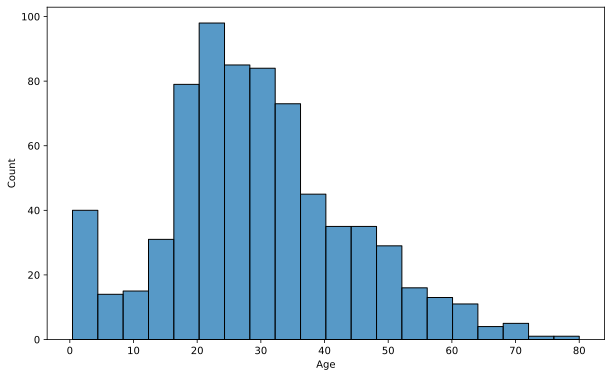

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data=titanic, x='Age');

In [16]:
median_age=titanic.Age.median()
titanic.Age.fillna(value=median_age, axis=0, inplace=True)

C:\Users\dutta\AppData\Local\Temp\ipykernel_2584\2820803741.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic.Age.fillna(value=median_age, axis=0, inplace=True)


In [17]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [18]:
titanic.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [19]:
titanic.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [20]:
titanic.SibSp.value_counts().sort_index()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64

In [21]:
titanic.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [22]:
titanic.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [23]:
titanic.drop(columns='Ticket', inplace=True)

In [24]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [25]:
titanic.Embarked.value_counts()

Embarked
S    644
C    170
Q     77
Name: count, dtype: int64

In [26]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [27]:
titanic[titanic.Fare>512]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
258,1,1,female,35.0,0,0,512.3292,C
679,1,1,male,36.0,0,1,512.3292,C
737,1,1,male,35.0,0,0,512.3292,C


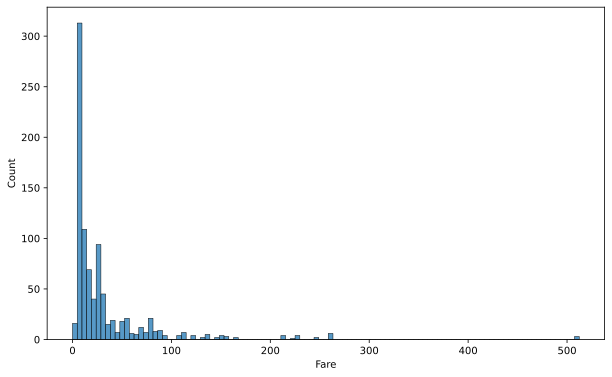

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=titanic, x='Fare');

In [29]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [30]:
titanic_modelling=titanic[['Age', 'Fare']].copy()
titanic_modelling.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [31]:
pclass_dummies=pd.get_dummies(titanic.Pclass, drop_first=True, prefix='Pclass').astype('int64')
titanic_modelling=pd.concat([titanic_modelling, pclass_dummies], axis=1, join='inner')

In [32]:
sex_dummies=pd.get_dummies(titanic.Sex, drop_first=True).astype('int64')
titanic_modelling=pd.concat([titanic_modelling, sex_dummies], axis=1, join='inner')
titanic_modelling

,Age,Fare,Pclass_2,Pclass_3,male
0,22.0,7.2500,0,1,1
1,38.0,71.2833,0,0,0
2,26.0,7.9250,0,1,0
3,35.0,53.1000,0,0,0
4,35.0,8.0500,0,1,1
...,...,...,...,...,...
886,27.0,13.0000,1,0,1
887,19.0,30.0000,0,0,0
888,28.0,23.4500,0,1,0
889,26.0,30.0000,0,0,1


In [33]:
sibsp_dummies=pd.get_dummies(titanic.SibSp, drop_first=True, prefix='SibSp').astype('int64')
titanic_modelling=pd.concat([titanic_modelling, sibsp_dummies], axis=1, join='inner')
titanic_modelling

,Age,Fare,Pclass_2,Pclass_3,male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,22.0,7.2500,0,1,1,1,0,0,0,0,0
1,38.0,71.2833,0,0,0,1,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0
3,35.0,53.1000,0,0,0,1,0,0,0,0,0
4,35.0,8.0500,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,1,0,1,0,0,0,0,0,0
887,19.0,30.0000,0,0,0,0,0,0,0,0,0
888,28.0,23.4500,0,1,0,1,0,0,0,0,0
889,26.0,30.0000,0,0,1,0,0,0,0,0,0


In [34]:
parch_dummies=pd.get_dummies(titanic.Parch, drop_first=True, prefix='Parch').astype('int64')
titanic_modelling=pd.concat([titanic_modelling, parch_dummies], axis=1, join='inner')
titanic_modelling

,Age,Fare,Pclass_2,Pclass_3,male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
887,19.0,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
888,28.0,23.4500,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
889,26.0,30.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
emberk_dummies=pd.get_dummies(titanic.Embarked, drop_first=True, prefix='Embarked').astype('int64')
titanic_modelling=pd.concat([titanic_modelling, emberk_dummies], axis=1, join='inner')
titanic_modelling

,Age,Fare,Pclass_2,Pclass_3,male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
887,19.0,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
888,28.0,23.4500,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
889,26.0,30.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
titanic_modelling=pd.concat([titanic_modelling, titanic.Survived], axis=1, join='inner')
titanic_modelling

,Age,Fare,Pclass_2,Pclass_3,male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Survived
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
887,19.0,30.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
888,28.0,23.4500,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
889,26.0,30.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
X,y=titanic_modelling.drop(columns=['Survived'], axis=1), titanic_modelling.Survived

In [38]:
X.Age.value_counts()

Age
28.00    202
24.00     30
22.00     27
18.00     26
19.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: count, Length: 88, dtype: int64

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [40]:
scaler=MinMaxScaler()

In [41]:
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## Logistic regression model

In [42]:
search_grid_lr={
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'tol':np.arange(0.0, 0.01, 0.0001).tolist(),
    'C':np.arange(0.01, 1, 0.01).tolist(),
    'fit_intercept':[True, False],
    'warm_start':[True, False],
    'l1_ratio':np.arange(0.0, 1, 0.01).tolist()
}
lr_model=LogisticRegression(class_weight='balanced',
                            solver='liblinear',
                                random_state=30)
search_lr=BayesSearchCV(estimator=lr_model,
                          search_spaces=search_grid_lr,
                          scoring='roc_auc',
                          cv=10,
                          n_jobs=-1,
                          error_score=np.nan,
                          random_state=42)

In [43]:
np.int = int
search_lr.fit(X=X_train, y=y_train)

c:\Users\dutta\.virtualenvs\DataTrained-MXeqPexY\lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


BayesSearchCV(cv=10, error_score=nan,
              estimator=LogisticRegression(class_weight='balanced',
                                           random_state=30,
                                           solver='liblinear'),
              n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'C': [0.01, 0.02, 0.03, 0.04, 0.05,
                                   0.060000000000000005, 0.06999999999999999,
                                   0.08, 0.09, 0.09999999999999999, 0.11, 0.12,
                                   0.13, 0.14, 0.15000000000000002, 0.16, 0.17,
                                   0.1800000000000...
                                     0.00030000000000000003, 0.0004, 0.0005,
                                     0.0006000000000000001, 0.0007, 0.0008,
                                     0.0009000000000000001, 0.001, 0.0011,
                                     0.0012000000000000001,
                                     0.0013000000000000002, 0.0014, 0.0015,
                                     0.0016, 0.0017000000000000001,
                                     0.0018000000000000002, 0.0019, 0.002,
                                     0.0021000000000000003, 0.0022, 0.0023,
                                     0.0024000000000000002, 0.0025,
                                     0.0026000000000000003, 0.0027, 0.0028,
                                     0.0029000000000000002, ...],
                             'warm_start': [True, False]})

In [44]:
print("Training performance of logistic regression\n")
y_predicted=search_lr.predict(X_train)
y_score=search_lr.predict_proba(X_train)[:,-1]
print(f'Best parameters: {search_lr.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_train), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_train)}')

Training performance of logistic regression

Best parameters: OrderedDict([('C', 0.8300000000000001), ('fit_intercept', True), ('l1_ratio', 0.24), ('penalty', 'l1'), ('solver', 'liblinear'), ('tol', 0.0037), ('warm_start', True)])

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       384
           1       0.70      0.77      0.73       239

    accuracy                           0.79       623
   macro avg       0.77      0.78      0.78       623
weighted avg       0.79      0.79      0.79       623
 

ROC AUC = 0.8597018828451883


In [45]:
print("Test performance of logistic regression\n")
y_predicted=search_lr.predict(X_test)
y_score=search_lr.predict_proba(X_test)[:,-1]
print(f'Best parameters: {search_lr.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_test), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_test)}')

Test performance of logistic regression

Best parameters: OrderedDict([('C', 0.8300000000000001), ('fit_intercept', True), ('l1_ratio', 0.24), ('penalty', 'l1'), ('solver', 'liblinear'), ('tol', 0.0037), ('warm_start', True)])

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       165
           1       0.69      0.81      0.74       103

    accuracy                           0.78       268
   macro avg       0.77      0.79      0.78       268
weighted avg       0.80      0.78      0.79       268
 

ROC AUC = 0.845189761694616


## Decision tree model

In [46]:
search_grid_dt={
    'splitter':['best', 'random'],
    'criterion':['gini', 'entropy'],
    'max_depth':list(range(1,20, 1)),
    'min_samples_leaf':list(range(5, 10, 1)),
    'max_features':['sqrt', 'log2'],
    'ccp_alpha': np.arange(0.0, 1.0, 0.001).tolist()
}
dt_model=DecisionTreeClassifier(class_weight='balanced',
                                random_state=30)
search_dt=BayesSearchCV(estimator=dt_model,
                          search_spaces=search_grid_dt,
                          scoring='roc_auc',
                          cv=10,
                          n_jobs=-1,
                          random_state=42)

In [47]:
np.int = int
search_dt.fit(X=X_train, y=y_train)

BayesSearchCV(cv=10,
              estimator=DecisionTreeClassifier(class_weight='balanced',
                                               random_state=30),
              n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'ccp_alpha': [0.0, 0.001, 0.002, 0.003, 0.004,
                                           0.005, 0.006, 0.007, 0.008,
                                           0.009000000000000001, 0.01, 0.011,
                                           0.012, 0.013000000000000001, 0.014,
                                           0.015, 0.016, 0.017,
                                           0.018000000000000002, 0.019, 0.02,
                                           0.021, 0.022, 0.023, 0.024, 0.025,
                                           0.026000000000000002, 0.027, 0.028,
                                           0.029, ...],
                             'criterion': ['gini', 'entropy'],
                             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19],
                             'max_features': ['sqrt', 'log2'],
                             'min_samples_leaf': [5, 6, 7, 8, 9],
                             'splitter': ['best', 'random']})

In [48]:
print("Training performance of Decision tree classifier\n")
y_predicted=search_dt.predict(X_train)
y_score=search_dt.predict_proba(X_train)[:,-1]
print(f'Best parameters: {search_dt.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_train), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_train)}')

Training performance of Decision tree classifier

Best parameters: OrderedDict([('ccp_alpha', 0.004), ('criterion', 'entropy'), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 6), ('splitter', 'best')])

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       384
           1       0.71      0.79      0.75       239

    accuracy                           0.79       623
   macro avg       0.78      0.79      0.79       623
weighted avg       0.80      0.79      0.80       623
 

ROC AUC = 0.8482882235006974


In [49]:
print("Test performance of Decision tree classifier\n")
y_predicted=search_dt.predict(X_test)
y_score=search_dt.predict_proba(X_test)[:,-1]
print(f'Best parameters: {search_dt.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_test), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_test)}')

Test performance of Decision tree classifier

Best parameters: OrderedDict([('ccp_alpha', 0.004), ('criterion', 'entropy'), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 6), ('splitter', 'best')])

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       165
           1       0.70      0.79      0.74       103

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.79      0.79      0.79       268
 

ROC AUC = 0.8268902618417182


## Random forest model

In [50]:
search_grid_rf={
    'n_estimators':list(range(100, 1000, 100)),
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':list(range(5, 10, 1)),
    'warm_start': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'ccp_alpha': np.arange(0.0, 1.0, 0.001).tolist()
}
rf_model=RandomForestClassifier(bootstrap=True,
                                random_state=30)
search_rf=BayesSearchCV(estimator=rf_model,
                          search_spaces=search_grid_rf,
                          scoring='roc_auc',
                          cv=10,
                          n_jobs=-1,
                          random_state=42)

In [51]:
np.int = int
search_rf.fit(X=X_train, y=y_train)

c:\Users\dutta\.virtualenvs\DataTrained-MXeqPexY\lib\site-packages\sklearn\ensemble\_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


BayesSearchCV(cv=10, estimator=RandomForestClassifier(random_state=30),
              n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'ccp_alpha': [0.0, 0.001, 0.002, 0.003, 0.004,
                                           0.005, 0.006, 0.007, 0.008,
                                           0.009000000000000001, 0.01, 0.011,
                                           0.012, 0.013000000000000001, 0.014,
                                           0.015, 0.016, 0.017,
                                           0.018000000000000002, 0.019, 0.02,
                                           0.021, 0.022, 0.023, 0.024, 0.025,
                                           0.026000000000000002, 0.027, 0.028,
                                           0.029, ...],
                             'class_weight': ['balanced', 'balanced_subsample'],
                             'criterion': ['gini', 'entropy'],
                             'min_samples_leaf': [5, 6, 7, 8, 9],
                             'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                              800, 900],
                             'warm_start': [True, False]})

In [52]:
print("Training performance of Random forest classifier\n")
y_predicted=search_rf.predict(X_train)
y_score=search_rf.predict_proba(X_train)[:,-1]
print(f'Best parameters: {search_rf.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_train), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_train)}')

Training performance of Random forest classifier

Best parameters: OrderedDict([('ccp_alpha', 0.004), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('min_samples_leaf', 5), ('n_estimators', 800), ('warm_start', True)])

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       384
           1       0.81      0.81      0.81       239

    accuracy                           0.85       623
   macro avg       0.84      0.84      0.84       623
weighted avg       0.85      0.85      0.85       623
 

ROC AUC = 0.9138554741980475


In [53]:
print("Test performance of Random forest classifier\n")
y_predicted=search_rf.predict(X_test)
y_score=search_rf.predict_proba(X_test)[:,-1]
print(f'Best parameters: {search_rf.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_test), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_test)}')

Test performance of Random forest classifier

Best parameters: OrderedDict([('ccp_alpha', 0.004), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('min_samples_leaf', 5), ('n_estimators', 800), ('warm_start', True)])

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       165
           1       0.69      0.75      0.72       103

    accuracy                           0.78       268
   macro avg       0.76      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268
 

ROC AUC = 0.8474551338629008


## XGBoost model

In [54]:
pos_class_weight=(y_train.shape[0] - sum(y_train)) / sum(y_train)
search_grid_xgb = {
    'booster':['gbtree', 'dart'],
    'max_depth': list(range(3, 10, 1)),
    'eta': np.arange(0.001, 0.1, 0.001).tolist(),
    'gamma': list(range(0, 1000, 10)),
    'subsample': np.arange(0.5, 1, 0.2).tolist(),
    'reg_alpha': np.arange(0.1, 0.5, 0.1).tolist(),
    'reg_lambda':np.arange(0.1, 0.5, 0.1).tolist()
}
xgb_model=XGBClassifier(scale_pos_weight=pos_class_weight,
                        random_state=30,
                        seed=30)
search_xgb=BayesSearchCV(estimator=xgb_model,
                          search_spaces=search_grid_xgb,
                          scoring='roc_auc',
                          cv=10,
                          n_jobs=-1,
                          random_state=42)

In [55]:
np.int = int
search_xgb.fit(X=X_train, y=y_train)

BayesSearchCV(cv=10,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=Non...
                                     0.026000000000000002, 0.027000000000000003,
                                     0.028, 0.029, 0.030000000000000002, ...],
                             'gamma': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100, 110, 120, 130, 140, 150, 160, 170,
                                       180, 190, 200, 210, 220, 230, 240, 250,
                                       260, 270, 280, 290, ...],
                             'max_depth': [3, 4, 5, 6, 7, 8, 9],
                             'reg_alpha': [0.1, 0.2, 0.30000000000000004, 0.4],
                             'reg_lambda': [0.1, 0.2, 0.30000000000000004, 0.4],
                             'subsample': [0.5, 0.7, 0.8999999999999999]})

In [56]:
print("Training performance of XGBoost classifier\n")
y_predicted=search_xgb.predict(X_train)
y_score=search_xgb.predict_proba(X_train)[:,-1]
print(f'Best parameters: {search_xgb.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_train), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_train)}')

Training performance of XGBoost classifier

Best parameters: OrderedDict([('booster', 'dart'), ('eta', 0.055), ('gamma', 0), ('max_depth', 6), ('reg_alpha', 0.2), ('reg_lambda', 0.2), ('subsample', 0.7)])

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       384
           1       0.91      0.89      0.90       239

    accuracy                           0.92       623
   macro avg       0.92      0.92      0.92       623
weighted avg       0.92      0.92      0.92       623
 

ROC AUC = 0.9809863145048814


In [57]:
print("Test performance of XGBoost classifier\n")
y_predicted=search_xgb.predict(X_test)
y_score=search_xgb.predict_proba(X_test)[:,-1]
print(f'Best parameters: {search_xgb.best_params_}\n')
print(classification_report(y_pred=y_predicted, y_true=y_test), "\n")
print(f'ROC AUC = {roc_auc_score(y_score=y_score, y_true=y_test)}')

Test performance of XGBoost classifier

Best parameters: OrderedDict([('booster', 'dart'), ('eta', 0.055), ('gamma', 0), ('max_depth', 6), ('reg_alpha', 0.2), ('reg_lambda', 0.2), ('subsample', 0.7)])

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       165
           1       0.76      0.69      0.72       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268
 

ROC AUC = 0.8238011179758752


## Best model
* Logistic regression is the best model out of all four types of models.
* This model has ROC AUC = 0.86 on training data and 0.85 on test data which are very close indicating that the model is a right fit to the data and generalizes well (unlikely to overfit).
* Other metrics are also close such as accuracy on train = 0.79 while 0.78 on test.
* Similarly this model has f1 = (0.82 and 0.73 for negative and positive classes respectively) while (0.81 and 0.74 for negative and positive classes respectively) on test data.

In [58]:
selected_model=search_lr.best_estimator_
print(f'Accuracy of the best model: {round(accuracy_score(y_pred=selected_model.predict(X_test), y_true=y_test), 2)}')
print(f'f1 score of the best model: {round(f1_score(y_pred=selected_model.predict(X_test), y_true=y_test), 2)}')
print(f'roc auc score of the best model: {round(roc_auc_score(y_score=selected_model.predict_proba(X_test)[:, -1], y_true=y_test), 2)}')

Accuracy of the best model: 0.78
f1 score of the best model: 0.74
roc auc score of the best model: 0.85
